# Deep autoencoders for ATLAS data compression

In [2]:
import sys
sys.version

'3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 15:50:08) [MSC v.1916 64 bit (AMD64)]'

## Data preprocessing 
We are going to load our given data from a csv file, apply all the necessary transformations using pandas and numpy in order to keep only the data we need, i.e. the "four-momentum" of the jet particles

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Change the path to point to where you have stored the dataset.
input_path = 'D:\Desktop\initial_dataset.csv'

raw_data = []    
print('Reading data at: ', input_path)
with open(input_path, 'r') as file:
    for line in file.readlines():
        line = line.replace(';', ',')
        line = line.rstrip(',\n')
        line = line.split(',')
        raw_data.append(line)
            
# Find the longest line in the data 
longest_line = max(raw_data, key = len)

# Set the maximum number of columns
max_col_num = len(longest_line)

# Set the columns names
col_names = ['event_ID', 'process_ID', 'event_weight', 'MET', 'MET_Phi']
meta_cols = col_names.copy()

# Create columns names for "four-momentum" of the jet particles
for i in range(1, (int((max_col_num-5)/5))+1):
        col_names.append('obj'+str(i))
        col_names.append('E'+str(i))
        col_names.append('pt'+str(i))
        col_names.append('eta'+str(i))
        col_names.append('phi'+str(i))

# Create a pandas dataframe to store the whole data
df = pd.DataFrame(raw_data, columns=col_names)
df.fillna(value=np.nan, inplace=True)

# Create a pandas dataframe to store only the data we need for training our AE (i.e. "four-momentum" of the jet particles)
data = pd.DataFrame(df.values, columns=col_names)
data.fillna(value=0, inplace=True)
# Drop unnecessary columns
data.drop(columns=meta_cols, inplace=True)

ignore_particles = ['e-', 'e+', 'm-', 'm+', 'g', 'b']
ignore_list = []
for i in range(len(data)):
    for j in data.loc[i].keys():
        if 'obj' in j:
            if data.loc[i][j] in ignore_particles:
                ignore_list.append(i)
                break

data.drop(ignore_list, inplace=True)

x = data.values.reshape([data.shape[0]*data.shape[1]//5,5])

temp_list = []
for i in range(x.shape[0]):
    if (x[i] == 0).all():
        temp_list.append(i)        
x1 = np.delete(x, temp_list, 0)
del x

temp_list = []
for i in range(x1.shape[0]):   
    if  (x1[i][0] == 'j'):
        continue
    else:
        temp_list.append(i)
        print(i, x1[i][0])
        
data = np.delete(x1, temp_list, 0)

col_names = ['obj', 'E', 'pt', 'eta', 'phi']
data_df = pd.DataFrame(data, columns=col_names)
# Drop the 'obj' column as it's unnecessary
data_df.drop(columns='obj', inplace=True)
data_df = data_df.astype('float32')

print('Data after preprocessing: ')
print(data_df)
# Standardize data Standard Scalar from sklearn
data_df[data_df.columns] = StandardScaler().fit_transform(data_df)
print('Normalized data:')
print(data_df)

Reading data at:  D:\Desktop\initial_dataset.csv
Data after preprocessing: 
                  E             pt       eta       phi
0      1.069460e+06  751597.000000  0.858186 -1.842170
1      4.576470e+05  110079.000000  2.102870  2.175010
2      4.964910e+04   30875.199219 -1.031890 -1.799200
3      6.760000e+05  640429.000000  0.330450  0.704554
4      1.239300e+06  602104.000000  1.343240 -0.550856
...             ...            ...       ...       ...
20360  7.318490e+05  722541.000000 -0.134499  2.563930
20361  2.688280e+05  259144.000000  0.153813  0.578428
20362  1.533400e+05   43931.500000  1.920140 -0.237382
20363  8.936890e+05  742040.000000 -0.618057 -3.104660
20364  1.075260e+05  106995.000000 -0.048565  2.436060

[20365 rows x 4 columns]
Normalized data:
              E        pt       eta       phi
0      1.467948  1.881091  0.567717 -1.014441
1      0.042805 -0.502422  1.397870  1.210629
2     -0.907576 -0.796698 -0.692885 -0.990640
3      0.551431  1.468054  0.215739  

Now we plot the data using the matplotlib library. The units reflect the normalization, but it's the shape that we care about.

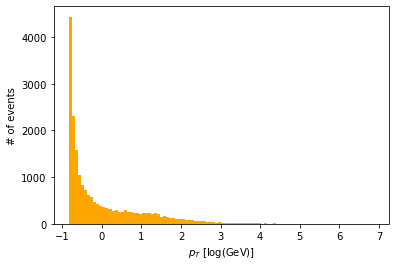

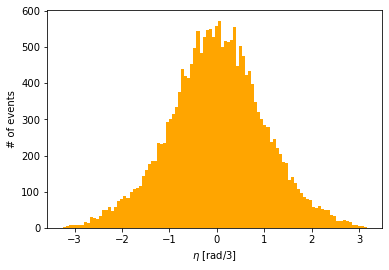

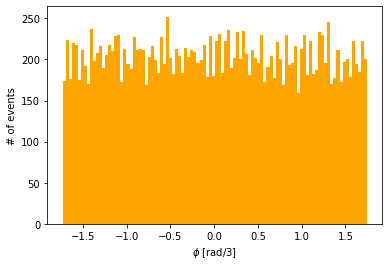

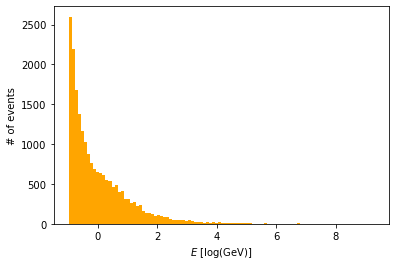

In [4]:
import matplotlib.pyplot as plt

unit_list = ['[log(GeV)]', '[rad/3]', '[rad/3]', '[log(GeV)]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']

branches=["pt","eta","phi", "E"]

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(data_df[branches[kk]], color='orange', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of events')
    plt.show()

## Preparing the data for the network

We are going to split the initial dataset into train and test set.
Then we are adding the two datasets as TensorDatasets to PyTorch (also loading all other classes we'll need later)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# shuffling the data before splitting
data_df = shuffle(data_df)

# split the data into train and test with a ratio of 20%
train_x, test_x = train_test_split(data_df, test_size=0.2, random_state=1)

train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

print('Train data shape: ')
print(train_x.shape)
print('Test data shape: ')
print(test_x.shape)

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

Train data shape: 
(16292, 4)
Test data shape: 
(4073, 4)


We now set things up to load the data, and we use a batch size that was optimized by previous students...note also that this is fastai v2, migration thanks to Jessica Lastow.

In [14]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

## Building the network
Here we build an autoencoder network which consists of the Encoder and Decoder.
The input layer of the network has 4 neurons, as we want to compress the "four-momentum" of the jet particles, which then goes to 200 neurons for the next layer, to 20 to 3 (as we want to compress the "four-momentum" of the jet particles to 3 features), and then all the way back to 4 which composes the Decoder of the network. Moreover, we use the tanh activation function for each layer in the network.

In [15]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()
        self.relu = True
        self.leakyRelu = nn.LeakyReLU()

    def encode(self, x):
        if self.relu:
            return self.en4(self.leakyRelu(self.en3(self.leakyRelu(self.en2(self.leakyRelu(self.en1(x)))))))
        else:
            return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        if self.relu:
            return self.de4(self.leakyRelu(self.de3(self.leakyRelu(self.de2(self.leakyRelu(self.de1(self.leakyRelu(x))))))))
        else:
            return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return '4-200-200-20-3-20-200-200-4'


model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
  (leakyRelu): LeakyReLU(negative_slope=0.01)
)

We now choose the Mean squared error (MSE) as our loss function since it is appropriate for a compression autoencoder, as it reflects the $\frac{(input-output)}{input}$ physical quantity that we want to minimize.

In [16]:
from fastai.metrics import mse, partial
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.test_utils import *

loss_function = nn.MSELoss()

weight_decay = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=weight_decay, loss_func=loss_function, cbs=recorder)

## Training the network

First, we want to find the best learning rate. The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rate is then either:

   - one tenth of the minimum before the divergence
   - when the slope is the steepest


Learning rate with the minimum loss: 0.005754399299621582
Learning rate with the steepest gradient: 0.005248074419796467


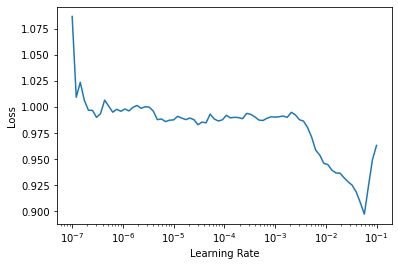

In [17]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

Now we want to run the training!

Hyperparameters:

   - n_epoch: The number of epochs, i.e how many times to run through all of the training data once.
   - lr: The learning rate. Here we choose lr_min from above.

In [18]:
import time

start = time.perf_counter() # Starts timer
# train our autoencoder for 200 epochs
learn.fit_one_cycle(100, lr_steep)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

epoch,train_loss,valid_loss,time
0,0.962200,0.913010,00:01
0,0.962200,0.913010,00:01
1,0.625002,0.370785,00:01
1,0.625002,0.370785,00:01
2,0.407513,0.311292,00:01
2,0.407513,0.311292,00:01
3,0.302772,0.222472,00:01
3,0.302772,0.222472,00:01
4,0.214798,0.154370,00:01
4,0.214798,0.154370,00:01


Training took 111.81454229999997 seconds


Then we plot the loss as a function of batches and epochs to check if we reach a plateau.

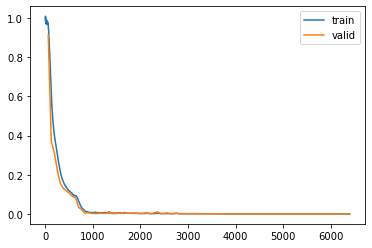

In [19]:
recorder.plot_loss()

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.

In [20]:
learn.validate()

(#1) [5.09262754349038e-05]

## Plotting the outputs of the network

Lazy-save of our output files (they'll also be on screen)

In [21]:
import os
save_dir = "D:\Desktop\AE_plots"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Construct the histograms from the dataset...

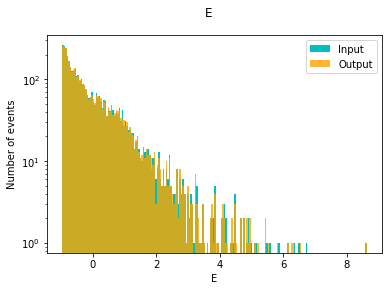

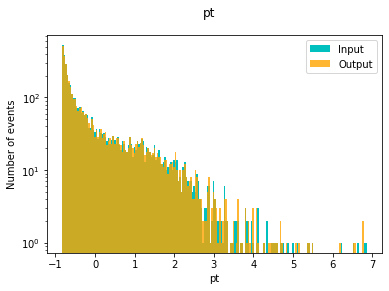

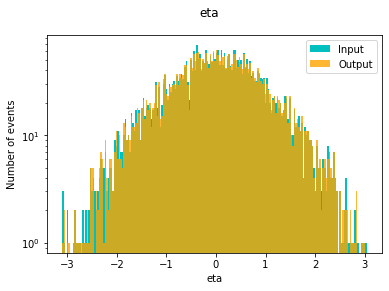

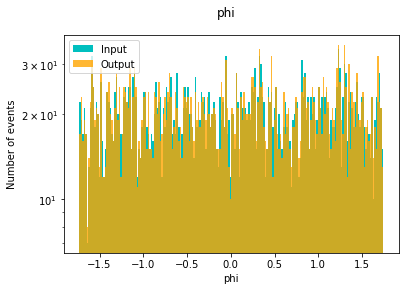

In [22]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = True # Option to save figure

# Histograms
idxs = (0, 10000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values, dtype=torch.float)

pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test_x.columns)
pred_df = pd.DataFrame(pred, columns=test_x.columns)

alph = 0.8
n_bins = 200

for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test_x.columns[kk])
    plt.xlabel(test_x.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test_x.columns[kk]+'.png'))
    plt.legend()

In [23]:
def getRatio(bin1,bin2):
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b2==0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    return bins   

rat = getRatio(n_hist_data,n_hist_pred)
#print(rat)